# EMATM0048 SDPA Coursework Part2

In [1]:
#!pip install requests
!rm data/*.csv

In [2]:
import json
import requests
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import time as timelibrary

import scipy 
from scipy import stats
import seaborn as sns 
import statsmodels.api as sm

In [3]:
start_date = "2022-12-01"
end_date = "2022-12-31"

## Step 1: Crawl OHLC dataset from Bitstamp

Data is come from Bitstamp, and the variables is Cryptocurrencies' prices.

1. Transform time to Unixstamp
2. Crawl every 12 hours data to require limit
3. Make a loop of step 2
4. Merge data from step 3
5. Transform to Dataframe and save to data/{currency_pair}.csv

In [4]:
# test api
test_data = requests.get('https://www.bitstamp.net/api/v2/ohlc/btcusd/', 
                            
                params = {
                "start":1672441200,
                "end":1672444800,
                "step":3600,
                "limit":1000,
                })

test_data

<Response [200]>

In [5]:
def gen_timestamp(time):
    """Generate Unix timestamp"""
    timestamp = int(timelibrary.mktime(timelibrary.strptime(str(time), "%Y-%m-%d")))
    return timestamp

def get_data(currency_pair, start, end):
    """Get OHLC data from Bitstamp"""

    url = f"https://www.bitstamp.net/api/v2/ohlc/{currency_pair}/"
    start = gen_timestamp(start)
    end = gen_timestamp(end)

    ohlc_data = []

    api_data = requests.get(url,                        
            params = {
            'start':start,
            'end':end,
            'step':3600,
            'limit':1000,
            })

    ohlc_data = api_data.json()['data']['ohlc']
    
    df = pd.DataFrame(ohlc_data)
    
    df.to_csv(f'data/{currency_pair}.csv', index=False)
    return df

In [6]:
get_data('btcusd', start_date, end_date)
get_data('ethusd', start_date, end_date)
get_data('btceur', start_date, end_date)

,close,high,low,open,timestamp,volume
0,16086,16105,16081,16099,1668848400,6.15307716
1,16098,16102,16081,16090,1668852000,5.45500836
2,16123,16133,16095,16098,1668855600,4.54949774
3,16109,16135,16099,16123,1668859200,5.86471944
4,16108,16116,16096,16110,1668862800,3.39383703
...,...,...,...,...,...,...
995,15471,15473,15441,15442,1672430400,12.87251643
996,15489,15550,15476,15476,1672434000,26.75486560
997,15479,15494,15479,15486,1672437600,7.65190163
998,15505,15512,15472,15483,1672441200,6.27030797


## Step 2: Data preparation & cleaing

1. Read data from csv
2. Sort by timestamp
3. Delete outlier date
4. Re-index

In [7]:
def timestamp_to_time(timestamp):
    """transform Unix timestamp to time"""
    time = datetime.datetime.fromtimestamp(timestamp)
    return time

In [8]:
# test
print(timestamp_to_time(1672441200))

2022-12-30 23:00:00


In [9]:
def cleaning(df):
    
    start = gen_timestamp(start_date)
    end = gen_timestamp(end_date)
    
    # delete outside date
    df = df[ df['timestamp'] >= start]
    df = df[ df['timestamp'] < end]
    
    # sort by date
    df['timestamp'] = df['timestamp'].astype(int)
    df = df.sort_values(by='timestamp')
    
    # re-index and add time col
    df.index = range(len(df))
    for i in range(df.shape[0]):
        df.loc[i, 'time'] = timestamp_to_time(df.loc[i, 'timestamp'])
    
    return df

In [10]:
# testing cleaning function
test_df = pd.read_csv('data/btcusd.csv')
test_df = cleaning(test_df)
test_df

,close,high,low,open,timestamp,volume,time
0,17161,17230,17131,17166,1669852800,240.539391,2022-12-01 00:00:00
1,17113,17167,17112,17161,1669856400,98.110238,2022-12-01 01:00:00
2,17124,17140,17093,17116,1669860000,105.129073,2022-12-01 02:00:00
3,17146,17168,17123,17124,1669863600,78.263376,2022-12-01 03:00:00
4,17141,17165,17136,17151,1669867200,64.009395,2022-12-01 04:00:00
...,...,...,...,...,...,...,...
715,16534,16564,16533,16561,1672426800,100.537649,2022-12-30 19:00:00
716,16560,16560,16531,16534,1672430400,58.093740,2022-12-30 20:00:00
717,16577,16650,16560,16560,1672434000,117.894399,2022-12-30 21:00:00
718,16566,16586,16554,16581,1672437600,219.626807,2022-12-30 22:00:00


In [11]:
# read saved data and clean it

btcusd = pd.read_csv('data/btcusd.csv')
btcusd = cleaning(btcusd)

ethusd = pd.read_csv('data/ethusd.csv')
ethusd = cleaning(ethusd)

btceur = pd.read_csv('data/btceur.csv')
btceur = cleaning(btcusd)

## Step 3: Perform exploratory analysis

1. Compute the mean, sum, range
2. Plot the close price trend
3. Plot the moving average of close price

In [12]:
btcusd.describe()

,close,high,low,open,timestamp,volume
count,720.000000,720.000000,720.000000,720.000000,7.200000e+02,720.000000
mean,16964.326389,16992.893056,16935.531944,16965.122222,1.671147e+09,75.617811
std,306.424820,315.071934,300.786894,306.270907,7.487654e+05,83.155131
min,16404.000000,16453.000000,16293.000000,16404.000000,1.669853e+09,6.003302
25%,16788.750000,16818.500000,16756.000000,16789.000000,1.670500e+09,31.810946
50%,16873.500000,16905.000000,16854.000000,16875.000000,1.671147e+09,50.302279
75%,17115.250000,17149.250000,17089.250000,17115.250000,1.671794e+09,89.504146
max,18231.000000,18373.000000,18086.000000,18221.000000,1.672441e+09,1024.099505


In [13]:
ethusd.describe()

,close,high,low,open,timestamp,volume
count,720.000000,720.000000,720.000000,720.000000,7.200000e+02,720.000000
mean,1238.937639,1242.295694,1235.523056,1239.084028,1.671147e+09,279.182864
std,39.987568,40.447513,39.754088,40.019588,7.487654e+05,515.929472
min,1162.700000,1169.500000,1150.600000,1162.700000,1.669853e+09,2.371208
25%,1209.575000,1212.075000,1206.075000,1209.375000,1.670500e+09,78.072282
50%,1229.400000,1233.650000,1226.150000,1229.400000,1.671147e+09,152.950531
75%,1272.125000,1274.625000,1268.425000,1272.225000,1.671794e+09,281.589519
max,1340.800000,1352.200000,1336.000000,1341.000000,1.672441e+09,6923.219697


In [14]:
btceur.describe()

,close,high,low,open,timestamp,volume
count,720.000000,720.000000,720.000000,720.000000,7.200000e+02,720.000000
mean,16964.326389,16992.893056,16935.531944,16965.122222,1.671147e+09,75.617811
std,306.424820,315.071934,300.786894,306.270907,7.487654e+05,83.155131
min,16404.000000,16453.000000,16293.000000,16404.000000,1.669853e+09,6.003302
25%,16788.750000,16818.500000,16756.000000,16789.000000,1.670500e+09,31.810946
50%,16873.500000,16905.000000,16854.000000,16875.000000,1.671147e+09,50.302279
75%,17115.250000,17149.250000,17089.250000,17115.250000,1.671794e+09,89.504146
max,18231.000000,18373.000000,18086.000000,18221.000000,1.672441e+09,1024.099505


In [15]:
def moving_average(lst, time):
    """moving average of lst with time period"""

    moving_averages = lst[:time]
    
    for i in range(len(lst)-time):
        lst1 = lst[i : i + time]
        moving_avg = round(sum(lst1) / time, 2)
        moving_averages.append(moving_avg)

    return moving_averages

In [16]:
ma_btcusd = moving_average(list(btcusd['close']), 12)
ma_ethusd = moving_average(list(ethusd['close']), 12)
ma_btceur = moving_average(list(btceur['close']), 12)

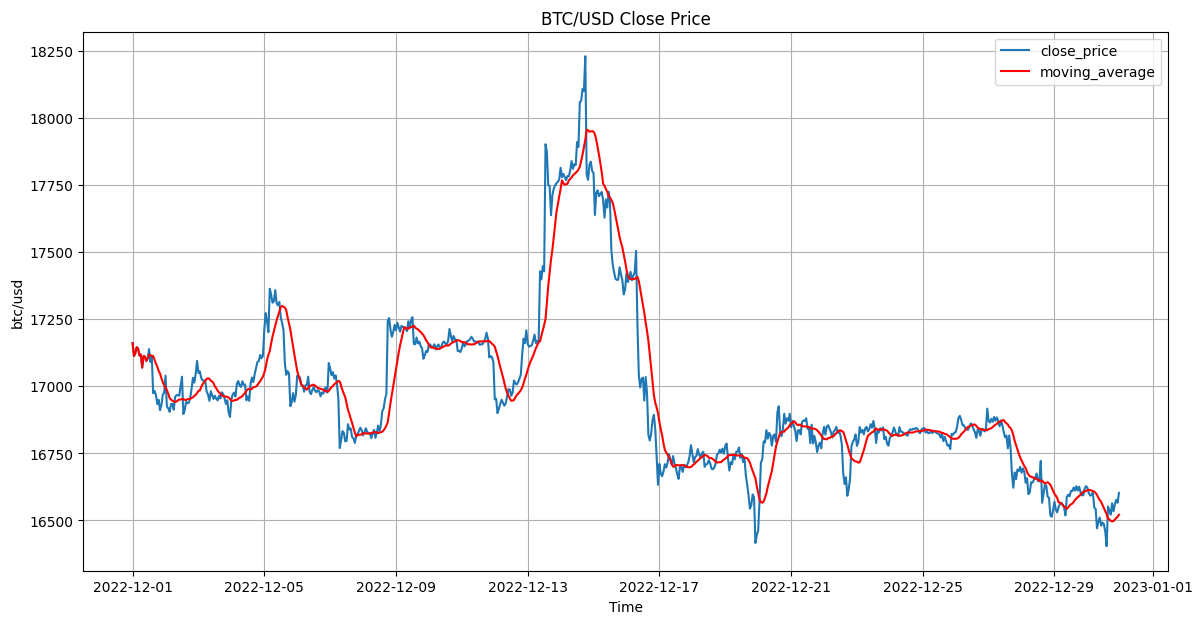

In [17]:
plt.figure(figsize=(14,7))

# fig, ax = plt.subplots()

plt.ylabel('btc/usd')
plt.xlabel('Time')
plt.title('BTC/USD Close Price')


plt.plot(btcusd['time'], btcusd['close'], label='close_price')
plt.plot(btcusd['time'], ma_btcusd, 'r-', label='moving_average')
plt.legend()
plt.grid()

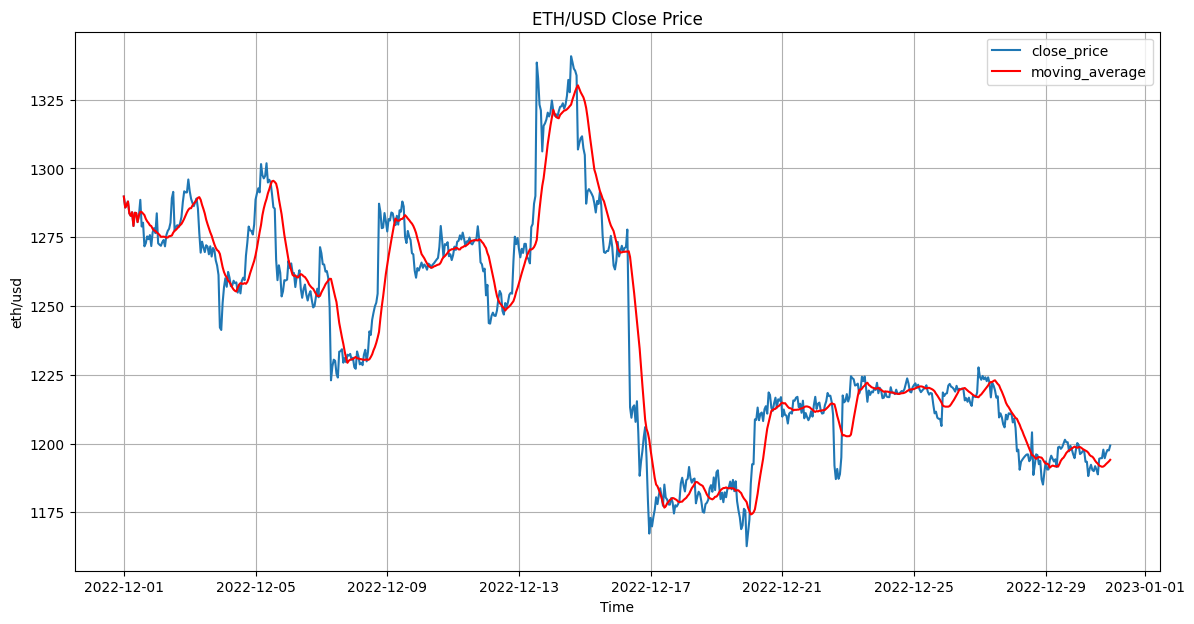

In [18]:
plt.figure(figsize=(14,7))

# fig, ax = plt.subplots()

plt.ylabel('eth/usd')
plt.xlabel('Time')
plt.title('ETH/USD Close Price')

plt.plot(ethusd['time'], ethusd['close'], label='close_price')
plt.plot(ethusd['time'], ma_ethusd, 'r-', label='moving_average')
plt.legend()
plt.grid()

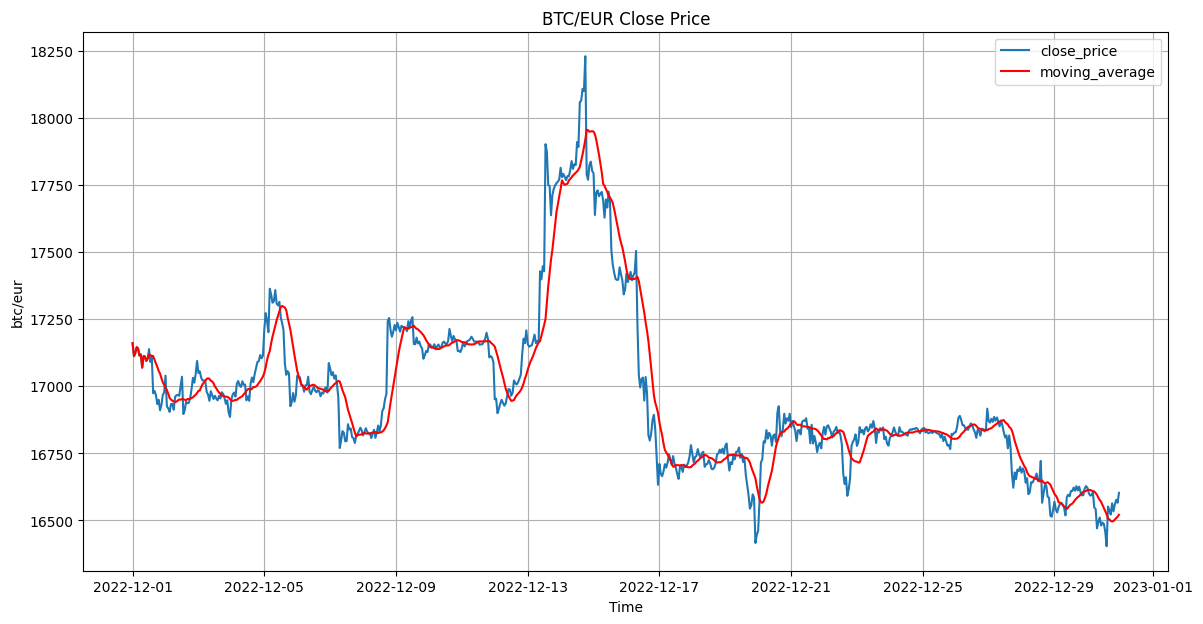

In [19]:
plt.figure(figsize=(14,7))

# fig, ax = plt.subplots()

plt.ylabel('btc/eur')
plt.xlabel('Time')
plt.title('BTC/EUR Close Price')

plt.plot(btceur['time'], btceur['close'], label='close_price')
plt.plot(btceur['time'], ma_btceur, 'r-', label='moving_average')
plt.legend()
plt.grid()

## Step 4: Ask questions about dataset

Using Return Ratio as a Dataset, $Return Ratio = (Price_{t+1}-Price_{t})/Price_{t}$

1. Do the return ratios of these three data sets follow a normal distribution?
2. Are there significant differences in the return ratios of the three sets of data?
3. Is there a relationship between volume and return ratio?

### 1. Do the return ratios of these three data sets follow a normal distribution?

In [20]:
def gen_return(price:list):
    """generate return ratio from close price"""
    return_ratio = [0]
    
    for i in range(len(price)-1):
        if (i+1)%24 == 0:
            return_ratio.append(0)
        else:   
            return_ratio.append((price[i+1]-price[i])/price[i])
    return return_ratio

def gen_norm(lst):
    arr = np.array(lst)
    norm = (arr-arr.mean())/arr.std()
    return norm

In [21]:
# generate return ratio
btcusd_return = gen_return(list(btcusd['close']))
ethusd_return = gen_return(list(ethusd['close']))
btceur_return = gen_return(list(btceur['close']))

In [22]:
def is_normal(lst:list):    
    # create Q-Q plot with 45-degree line
    fig = sm.qqplot(gen_norm(lst), line='45')

    # run Shapiro-Wilk test
    s,p = stats.shapiro(lst)
    if p< 0.05:
        print("This data set is not normally distributed.")
    else:
        print("This data set is normally distributed.")

Test btcusd:
This data set is not normally distributed.


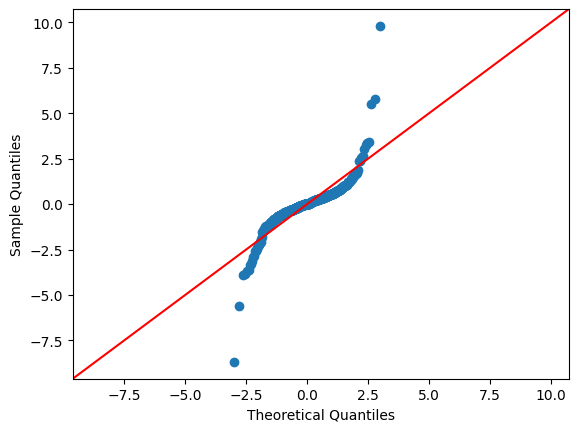

In [23]:
print("Test btcusd:")
is_normal(btcusd_return)

Test ethusd:
This data set is not normally distributed.


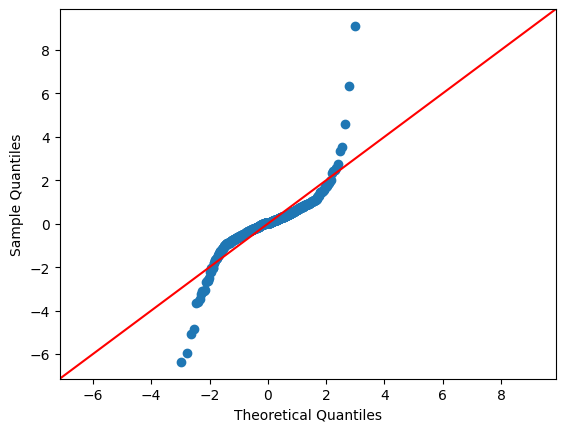

In [24]:
print("Test ethusd:")
is_normal(ethusd_return)

Test btceur:
This data set is not normally distributed.


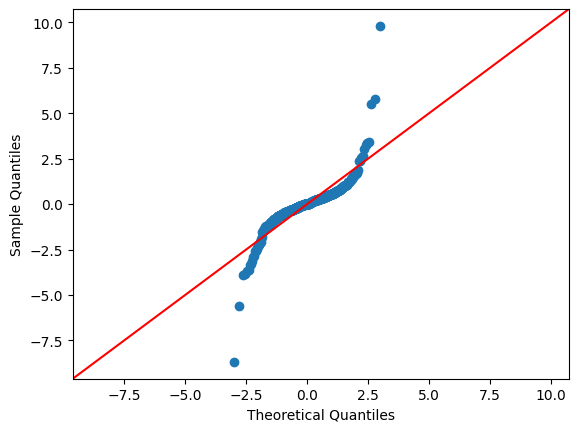

In [25]:
print("Test btceur:")
is_normal(btceur_return)

This experiment was conducted to test whether the data sets obeyed normal distribution by plotting QQ plot and Shapiro-Wilk test.
When the curve on the QQ plot is closer to the 45 degree line, the data are closer to the normal distribution.
The null hypothesis of Shapiro-Wilk test is that the data obeys normal distribution, and if the p-value is greater than or equal to 0.05, the null hypothesis cannot be rejected.

In this experiment, the p-values of all three groups of data are much less than 0.05, which means that they do not follow normal distribution. The QQ plot also shows that their distributions are far from the 45 degree line.

### 2. Are there significant differences in the return ratios of the three sets of data?

The results from Experiment 1 showed that all three sets of data were not normally distributed, so the Mann-Whitney U test was chosen to be used in this experiment.

The Mann-Whitney U test is a hypothesis test for non-normally distributed data sets with the null hypothesis that the two samples have the same distribution.

In [26]:
def is_same(x, y):
    u,p =  scipy.stats.mannwhitneyu(x, y)
    print("p = " + str(p))
    
    if p< 0.05:
        print("They do not have the same distribution.")
    else:
        print("They have the same distribution.")

In [27]:
print("test btcusd and btceur")
is_same(btcusd_return, btceur_return)

test btcusd and btceur
p = 1.0
They have the same distribution.


In [28]:
print("test btcusd and ethusd")
is_same(btcusd_return, ethusd_return)

test btcusd and ethusd
p = 0.8264742765345422
They have the same distribution.


In [29]:
print("test ethusd and btceur")
is_same(ethusd_return, btceur_return)

test ethusd and btceur
p = 0.8264742765345422
They have the same distribution.


The p-values of the Mann-Whitney U test between these three data sets were all much greater than 0.05, i.e., they had similar distribution characteristics. However, the p-value between etcusd and etceur is close to 1, which means that the distribution is almost the same.

### 3. Is there a relationship between volume and return ratio?


In [30]:
btcusd_vol = btcusd['volume']
btcusd_vol = list(btcusd_vol)


btceur_vol = btceur['volume']
btceur_vol = list(btceur_vol)


ethusd_vol = ethusd['volume']
ethusd_vol = list(ethusd_vol)

In [31]:
for i in range(len(btcusd_vol)):
    if btcusd.loc[i, 'close'] - btcusd.loc[i, 'open'] < 0:
        btcusd_vol[i] = 0 - btcusd_vol[i]
        
for i in range(len(ethusd_vol)):
    if ethusd.loc[i, 'close'] - ethusd.loc[i, 'open'] < 0:
        ethusd_vol[i] = 0 - ethusd_vol[i]
        
for i in range(len(btceur_vol)):
    if btceur.loc[i, 'close'] - btceur.loc[i, 'open'] < 0:
        btceur_vol[i] = 0 - btceur_vol[i]

This data set is not normally distributed.
This data set is not normally distributed.
This data set is not normally distributed.


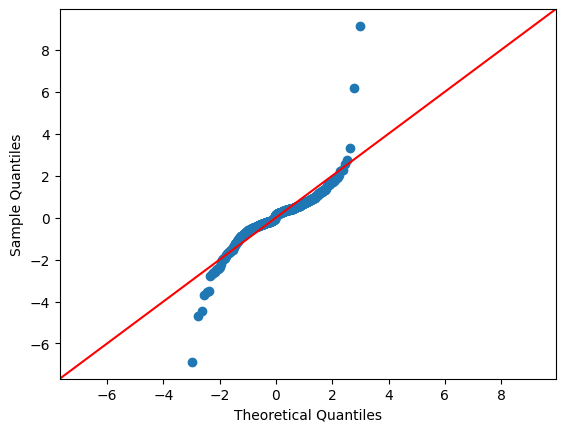

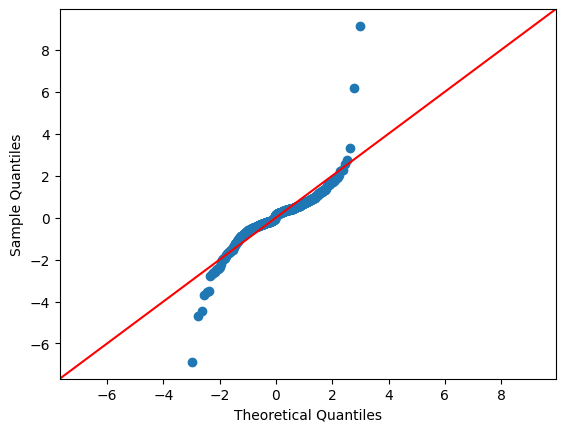

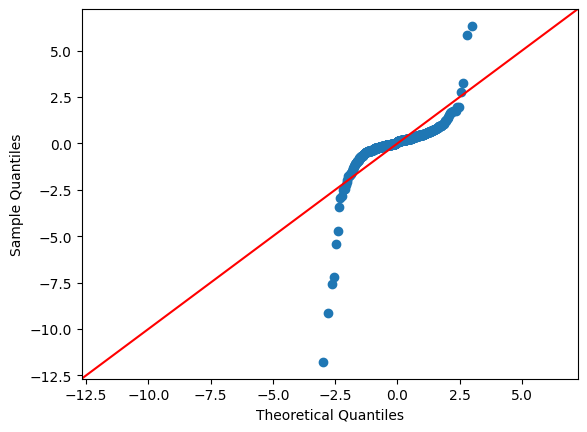

In [32]:
is_normal(btcusd_vol)
is_normal(btceur_vol)
is_normal(ethusd_vol)

In [33]:
print('begin test btcusd')
is_same(btcusd_return, btcusd_vol)
print('====end====','\n')
print('begin test btceur')
is_same(btceur_return, btceur_vol)
print('====end====','\n')
print('begin test ethusd')
is_same(ethusd_return, ethusd_vol)
print('====end====')

begin test btcusd
p = 0.3154945373640624
They have the same distribution.
====end==== 

begin test btceur
p = 0.3154945373640624
They have the same distribution.
====end==== 

begin test ethusd
p = 0.36150448075105246
They have the same distribution.
====end====


First, the Shapiro-Wilk test was conducted on the volume of the three groups of virtual currencies, and the results showed that they did not follow a normal distribution.
Then, the Mann-Whitney U test was used to analyze their respective return ratios and volume, and the results showed that their distributions were not significantly different.

 P.S. Volume needs to be defined as positive or negative depending on the direction of price change.

## Step 5: Summarise

In this project, the first step was to obtain the close price, volume and etc. of the three cryptocurrencies via the Bitstamp api.

After removing the anomalies and reordering the data, we calculated the mean standard deviation of these data.
We then plotted the data using the moving average and the original close price.

In the fifth part of this experiment, we first analyze the normal distribution of return ratios for each group. Since the experimental data do not follow a normal distribution, we use the Shapiro-Wilk test to analyze the distribution similarity. The results show that the distributions of the three data groups are highly similar.

Next, we analyze the relationship between the volume and reporting ratio distributions, again showing that they are similar and not normally distributed.


I believe that the same cryptocurrency price movements between different trading institutions can be analysed in a subsequent study. When analysing the data, the price trends can be summarised in several line segments to improve the overall readability.